# Burglary data from Chicago

In [1]:
%matplotlib inline
from common import *

In [2]:
import pickle
import unittest.mock as mock
import open_cp.prohotspot

In [3]:
datadir = os.path.join("..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
northside, grid = load(datadir, "South")
savefigures = False

In [4]:
training_start = datetime.datetime(2016, 1, 1)
start_time = datetime.datetime(2016, 9, 1)
end_time = datetime.datetime(2016, 12, 31)

In [5]:
import lzma
with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

In [6]:
points.time_range

(numpy.datetime64('2001-01-01T00:01:00.000'),
 numpy.datetime64('2017-08-09T22:00:00.000'))

In [7]:
ct = end_time + datetime.timedelta(days=1)
mask = (points.timestamps >= training_start) & (points.timestamps < ct)
points = points[mask]

In [8]:
points = open_cp.geometry.intersect_timed_points(points, northside)

In [14]:
days_range = (points.time_range[1] - points.time_range[0]) / np.timedelta64(1, "D")
points.time_range, points.number_data_points, points.number_data_points / days_range

((numpy.datetime64('2016-01-02T13:00:00.000'),
  numpy.datetime64('2016-12-31T23:36:00.000')),
 1933,
 5.304003841492694)

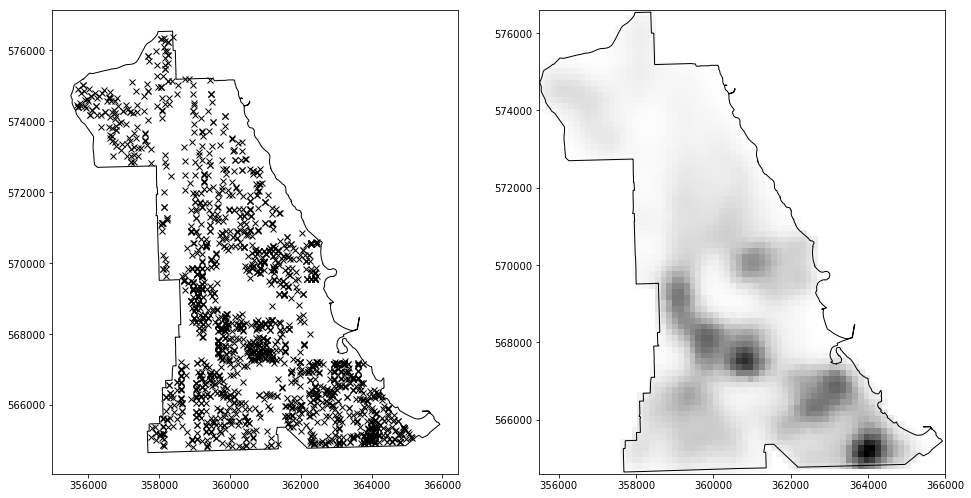

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
None

In [16]:
if savefigures:
    fig.savefig("northside_events.pdf")

# Make the predictions

We'll compare the "naive" predictor to a KDE based one.

In [17]:
def make_predictions(start_time):
    start = start_time
    all_data = {}
    while start <= end_time:
        end = start + datetime.timedelta(days=1)
        predictor = open_cp.naive.CountingGridKernel(grid_width=grid.xsize, region=grid.region())
        predictor.data = points[points.timestamps < start]
        prediction1 = predictor.predict()
        prediction1.mask_with(grid)
        prediction1 = prediction1.break_ties()
        prediction1 = prediction1.renormalise()

        #predictor = open_cp.kde.KDE(grid=grid)
        #predictor.data = points[points.timestamps < start]
        #predictor.space_kernel = open_cp.kde.GaussianNearestNeighbourProvider(10)
        #predictor.time_unit = np.timedelta64(1, "D")
        #predictor.time_kernel = open_cp.kde.ExponentialTimeKernel(45)
        predictor = open_cp.prohotspot.ProspectiveHotSpotContinuous(grid_size=50, time_unit=np.timedelta64(250,"h"))
        predictor.data = points[points.timestamps < start]
        predictor.weight = open_cp.prohotspot.ClassicWeight(8*7*24 / 250, 400 / 50)
        prediction2 = predictor.predict(start, start)
        prediction2.samples = 5
        prediction2 = open_cp.predictors.GridPredictionArray.from_continuous_prediction_grid(prediction2, grid)
        prediction2.mask_with(grid)
        prediction2 = prediction2.break_ties()
        prediction2 = prediction2.renormalise()
        all_data[start] = (prediction1, prediction2)

        start = end
        print(end, end_time, file=sys.__stdout__)
    return all_data

all_data = make_predictions(start_time)

#with lzma.open("preds_temp.pic.xz", "wb") as file:
#    pickle.dump(all_data, file)
#os.stat("preds_temp.pic.xz").st_size / 1024 / 1024

In [18]:
#with lzma.open("preds_temp.pic.xz", "rb") as file:
#    all_data = pickle.load(file)

# Optimise KDE

The KDE method doesn't out-perform the `naive` method at low coverage levels.  But optimising the KDE method is soooo slow...

In [19]:
def not_acting_on_right_now():
    def score(k, tl):
        coverages = [x/2 for x in range(1,50)]
        start_time = datetime.datetime(2016, 9, 1)
        end_time = datetime.datetime(2016, 9, 7)

        start = start_time
        result = {}
        while start <= end_time:
            end = start + datetime.timedelta(days=1)
            tps = points[(points.timestamps >= start) & (points.timestamps < end)]
            if tps.number_data_points == 0:
                continue

            predictor = open_cp.kde.KDE(grid=grid)
            predictor.data = points[points.timestamps < start]
            predictor.space_kernel = open_cp.kde.GaussianNearestNeighbourProvider(k)
            predictor.time_unit = np.timedelta64(1, "D")
            predictor.time_kernel = open_cp.kde.ExponentialTimeKernel(tl)
            prediction = predictor.predict()

            result[start] = open_cp.evaluation.hit_rates(prediction, tps, coverages)
            start = end
        return result

    d = score(10, 45)
    d

# Some plots

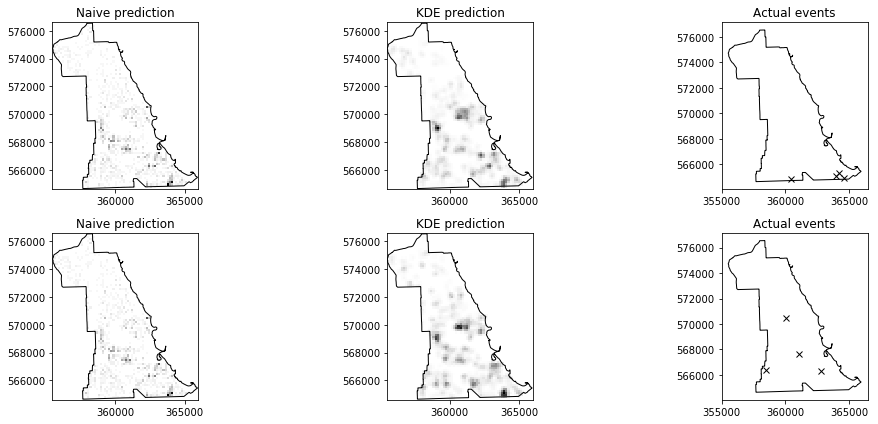

In [20]:
fig, all_axes = plt.subplots(ncols=3, nrows=2, figsize=(16,6))

for start, axes in zip([datetime.datetime(2016,11,5), datetime.datetime(2016,10,23)], all_axes):
    for ax in axes:
        ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
        ax.set_aspect(1)

    end = start + datetime.timedelta(days=1)

    naive, kde = all_data[start]
    axes[0].pcolor(*naive.mesh_data(), naive.intensity_matrix, cmap="Greys", rasterized=True)
    axes[0].set_title("Naive prediction")
    axes[1].pcolor(*kde.mesh_data(), kde.intensity_matrix, cmap="Greys", rasterized=True)
    axes[1].set_title("KDE prediction")
    tps = points[(points.timestamps >= start) & (points.timestamps < end)]
    axes[2].scatter(tps.xcoords, tps.ycoords, marker="x", color="black", linewidth=1)
    axes[2].set_title("Actual events")
    fig.tight_layout()

In [21]:
if savefigures:
    fig.savefig("northside_preds.pdf")

# Score the predictions

In [22]:
def process_to_scores(all_data, func, min_size=1):
    data = {}
    for start in all_data:
        end = start + datetime.timedelta(days=1)
        tps = points[(points.timestamps >= start) & (points.timestamps < end)]
        if tps.number_data_points < min_size:
            continue
        data[start] = ( func(all_data[start][0], tps), func(all_data[start][1], tps) )
    return data

# Hitrate

In [23]:
coverages = [x/2 for x in range(1,10)] + list(range(5,20)) + list(range(20,100,5))
hitrates = process_to_scores(all_data, lambda p, t : open_cp.evaluation.hit_rates(p, t, coverages))

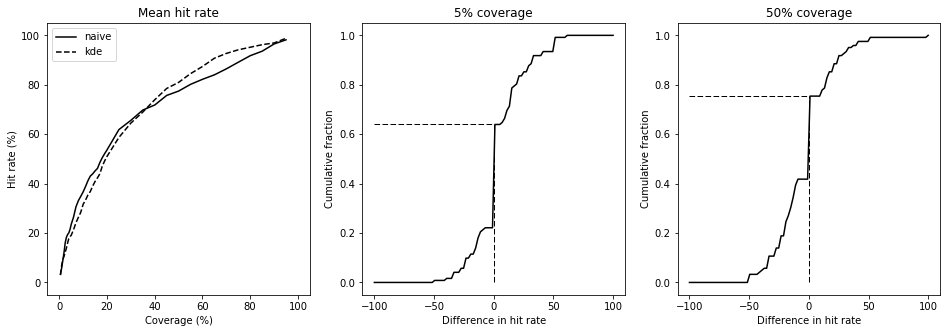

In [24]:
fig, axes = plt.subplots(ncols=3, figsize=(16,5))
data = hitrates

frame = pd.DataFrame({k : v[0] for k, v in data.items()}).T.describe().T
ax = axes[0]
ax.plot(frame["mean"]*100, color="black", linestyle="-", label="naive")
frame = pd.DataFrame({k : v[1] for k, v in data.items()}).T.describe().T
ax.plot(frame["mean"]*100, color="black", linestyle="--", label="kde")
ax.legend()
ax.set(xlabel="Coverage (%)", ylabel="Hit rate (%)")
ax.set(xlim=[-5,105], ylim=[-5,105])
ax.set_title("Mean hit rate")

def plot(ax, cov):
    keys = list(data)
    x = [data[k][0][cov]*100 for k in keys]
    y = [data[k][1][cov]*100 for k in keys]
    diff = np.asarray([xx - yy for xx, yy in zip(x, y)])
    cumulative_df_plot_func(ax, diff, -100, 100)
    
plot(axes[1], 5)
plot(axes[2], 50)
axes[1].set_title("5% coverage")
axes[2].set_title("50% coverage")
for ax in axes[1:]:
    ax.set(xlabel="Difference in hit rate")
    ax.set(ylabel="Cumulative fraction")

In [25]:
if savefigures:
    fig.savefig("northside_hitrate.pdf")

In [26]:
#with lzma.open("case_study_hit_rates.pic.xz", "wb") as f:
#    pickle.dump(hitrates, f)

In [27]:
coverages = [x/2 for x in range(1,10)] + list(range(5,20)) + list(range(20,100,5))
hitcounts = process_to_scores(all_data, lambda p, t : open_cp.evaluation.hit_counts(p, t, coverages))

In [28]:
#with lzma.open("case_study_hit_counts.pic.xz", "wb") as f:
#    pickle.dump(hitcounts, f)

## Ranking

Higher is better.

In [29]:
rankings = process_to_scores(all_data, open_cp.evaluation.ranking_score)
data = rankings

In [30]:
means = [PairedItem(k, np.mean(data[k][0]), np.mean(data[k][1])) for k in data]
deltas = [np.sum(data[k][0] > data[k][1]) / len(data[k][0]) for k in data]

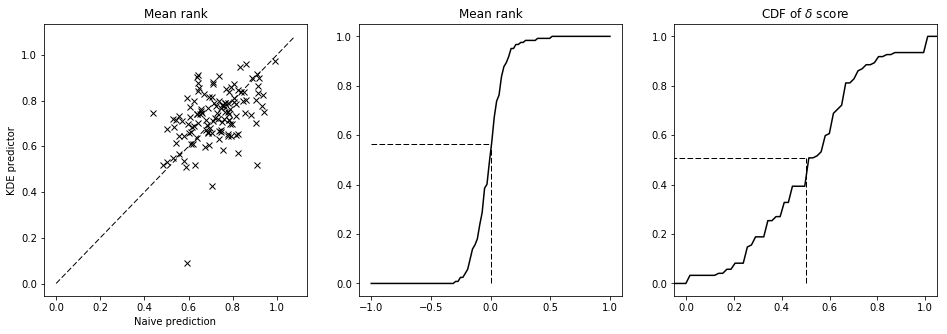

In [31]:
fig, axes = plt.subplots(ncols=3, figsize=(16,5))

scatter_uni_paired_plot_func(axes[0], means)
axes[0].set(xlabel="Naive prediction", ylabel="KDE predictor", title="Mean rank")
comparison_uni_paired(-1, 1)(axes[1], means)
axes[1].set(title="Mean rank")
cumulative_df_plot_func(axes[2], np.asarray(deltas), -0.5, 1.2, midpoint=0.5)
axes[2].set(title="CDF of $\delta$ score", xlim=[-0.05,1.05], ylim=[-0.05,1.05])
None

In [32]:
if savefigures:
    fig.savefig("northside_ranking.pdf")

# Likelihood

In [33]:
likelihood = process_to_scores(all_data, open_cp.evaluation.likelihood)

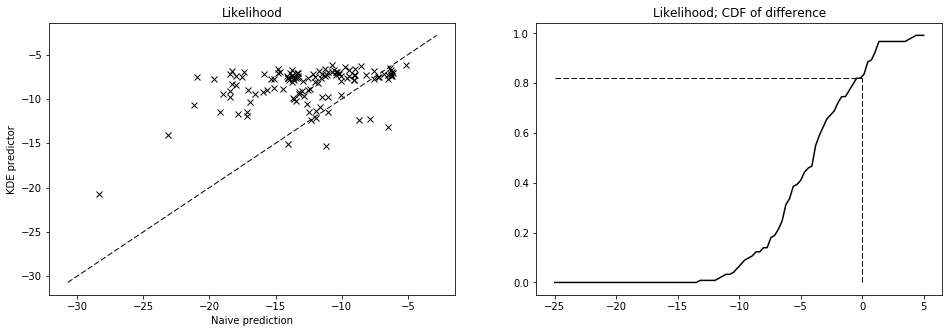

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

data = likelihood
data = [PairedItem(k, data[k][0], data[k][1]) for k in data]

scatter_uni_paired_plot_func(axes[0], data)
axes[0].set(xlabel="Naive prediction", ylabel="KDE predictor", title="Likelihood")
comparison_uni_paired(-25, 5)(axes[1], data)
axes[1].set(title="Likelihood; CDF of difference")
None

In [35]:
if savefigures:
    fig.savefig("northside_likelihood.pdf")

# KDE

Smaller is better; KDE kills naive!

In [36]:
data = process_to_scores(all_data, lambda a,b : open_cp.evaluation.score_kde(a,b,grid), min_size=3)

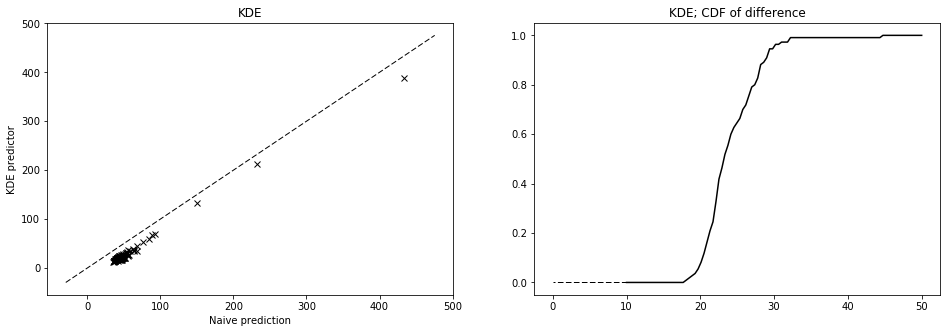

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

data1 = [PairedItem(k, data[k][0], data[k][1]) for k in data]

scatter_uni_paired_plot_func(axes[0], data1)
axes[0].set(xlabel="Naive prediction", ylabel="KDE predictor", title="KDE")
comparison_uni_paired(10, 50)(axes[1], data1)
axes[1].set(title="KDE; CDF of difference")
None

In [38]:
kde_bandwidth = {k :
    process_to_scores(all_data, lambda a,b : open_cp.evaluation.score_kde_fixed_bandwidth(a,b,grid,k), min_size=3)
    for k in [10, 40, 70, 100, 250, 1000]}

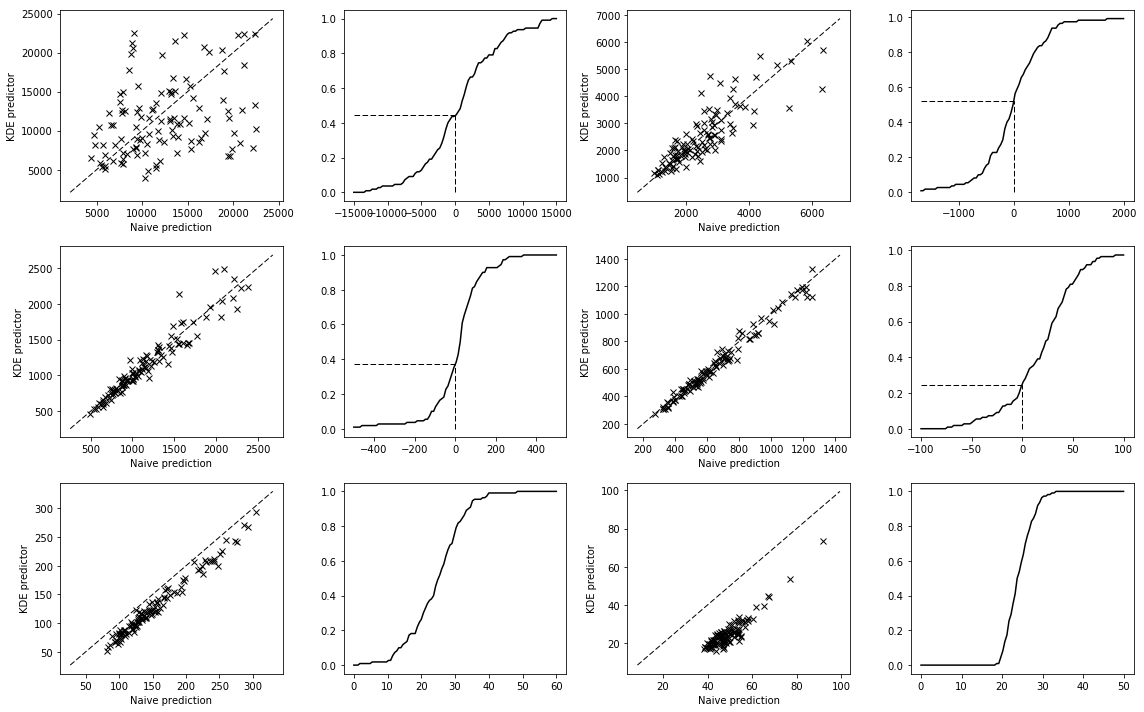

In [39]:
fig, axe_rows = plt.subplots(ncols=4, nrows=3, figsize=(16,10))

axe_rows = axe_rows.reshape((6,2))

ranges = [(-15000,15000), (-1700,2000), (-500,500),
         (-100,100), (0,60), (0,50)]

for axes, data, ran in zip(axe_rows, kde_bandwidth.values(), ranges):
    data1 = [PairedItem(k, data[k][0], data[k][1]) for k in data]

    scatter_uni_paired_plot_func(axes[0], data1)
    axes[0].set(xlabel="Naive prediction", ylabel="KDE predictor")
    comparison_uni_paired(*ran)(axes[1], data1)
    
fig.tight_layout()

In [40]:
if savefigures:
    fig.savefig("northside_kde.pdf")

# Scoring rules

In [41]:
brier = process_to_scores(all_data, open_cp.evaluation.brier_score)

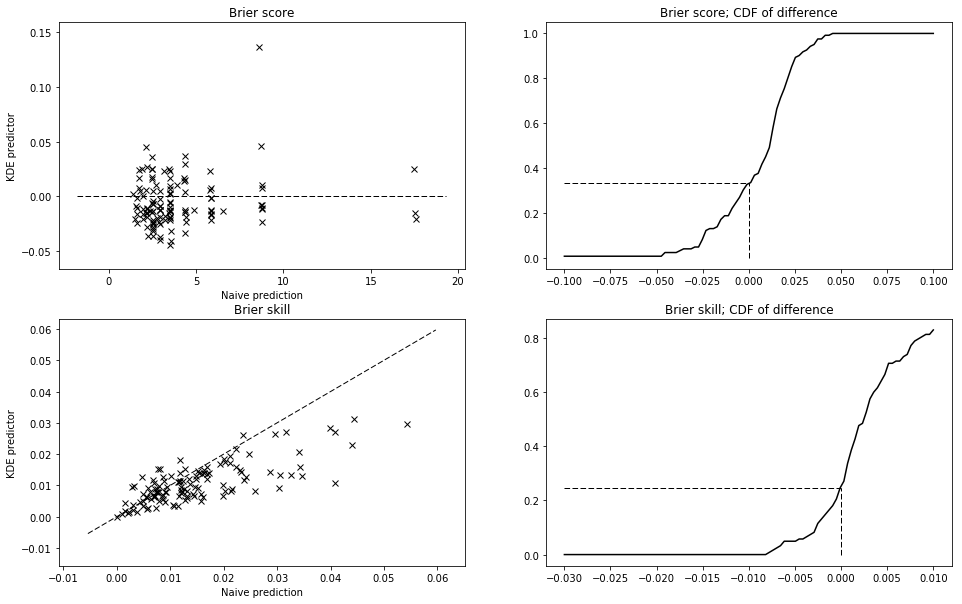

In [42]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,10))

d = 1e9
data = [PairedItem(k, brier[k][0][0] * d, brier[k][1][0] * d) for k in brier]

ax = axes[0][0]
scatter_uni_paired_plot_func_diffs(ax, data)
ax.set(xlabel="Naive prediction", ylabel="KDE predictor", title="Brier score")
comparison_uni_paired(-.1, .1)(axes[0][1], data)
axes[0][1].set(title="Brier score; CDF of difference")

data = [PairedItem(k, brier[k][0][1], brier[k][1][1]) for k in brier]

ax = axes[1][0]
scatter_uni_paired_plot_func(ax, data)
ax.set(xlabel="Naive prediction", ylabel="KDE predictor", title="Brier skill")
comparison_uni_paired(-.03, .01)(axes[1][1], data)
axes[1][1].set(title="Brier skill; CDF of difference")
None

In [43]:
po_brier = process_to_scores(all_data, open_cp.evaluation.poisson_crps_score)

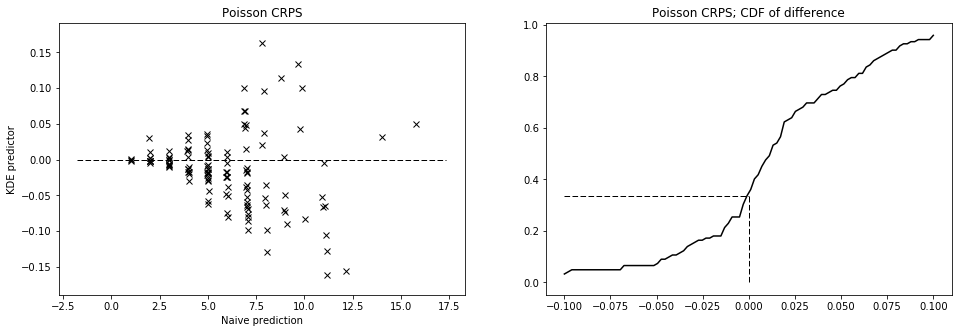

In [44]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

data = [PairedItem(k, po_brier[k][0], po_brier[k][1]) for k in po_brier]

ax = axes[0]
scatter_uni_paired_plot_func_diffs(ax, data)
ax.set(xlabel="Naive prediction", ylabel="KDE predictor", title="Poisson CRPS")
comparison_uni_paired(-.1, .1)(axes[1], data)
axes[1].set(title="Poisson CRPS; CDF of difference")
None

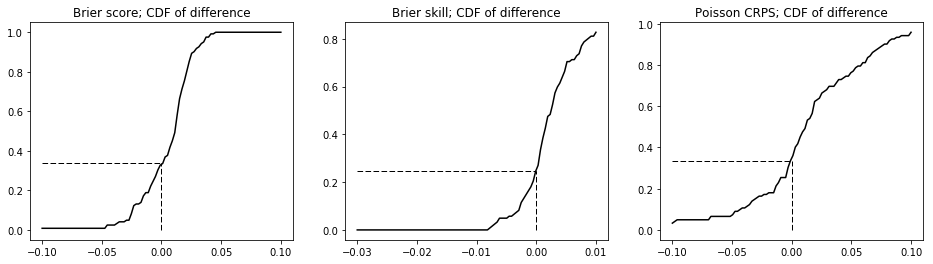

In [45]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

d = 1e9
data = [PairedItem(k, brier[k][0][0] * d, brier[k][1][0] * d) for k in brier]
comparison_uni_paired(-.1, .1)(axes[0], data)
axes[0].set(title="Brier score; CDF of difference")

data = [PairedItem(k, brier[k][0][1], brier[k][1][1]) for k in brier]
comparison_uni_paired(-.03, .01)(axes[1], data)
axes[1].set(title="Brier skill; CDF of difference")

data = [PairedItem(k, po_brier[k][0], po_brier[k][1]) for k in po_brier]
comparison_uni_paired(-.1, .1)(axes[2], data)
axes[2].set(title="Poisson CRPS; CDF of difference")
None

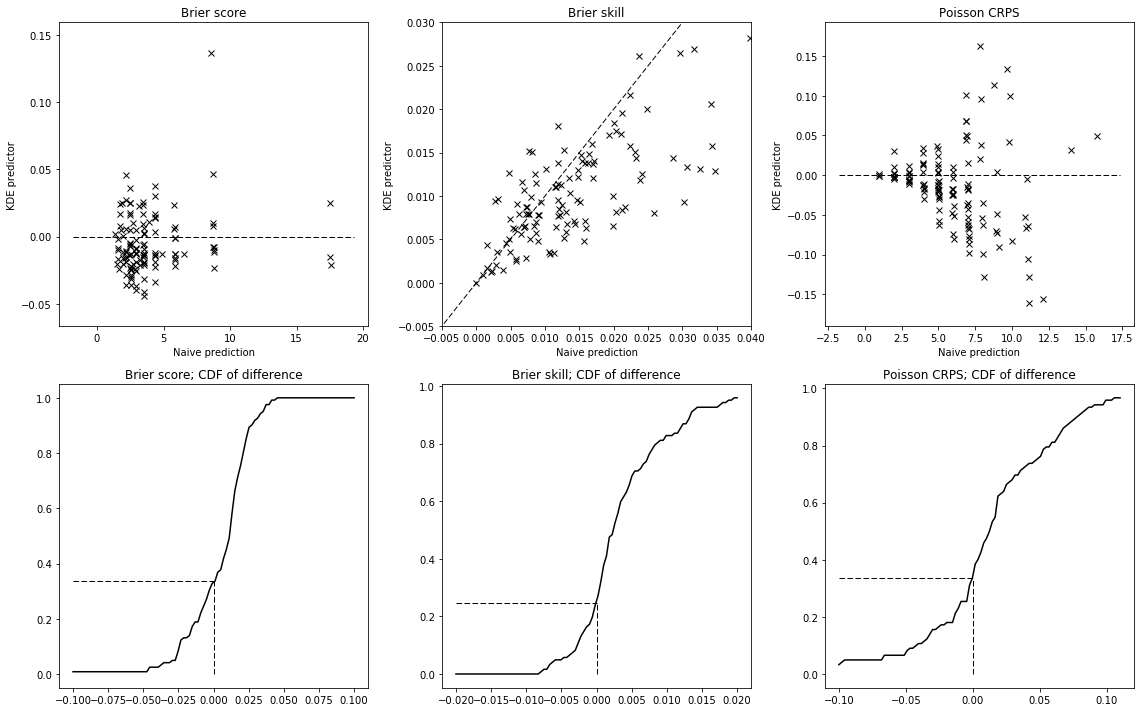

In [46]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16,10))

d = 1e9
data = [PairedItem(k, brier[k][0][0] * d, brier[k][1][0] * d) for k in brier]
ax = axes[0][0]
scatter_uni_paired_plot_func_diffs(ax, data)
ax.set(xlabel="Naive prediction", ylabel="KDE predictor", title="Brier score")
ax = axes[1][0]
comparison_uni_paired(-.1, .1)(ax, data)
ax.set(title="Brier score; CDF of difference")

data = [PairedItem(k, brier[k][0][1], brier[k][1][1]) for k in brier]
ax = axes[0][1]
scatter_uni_paired_plot_func(ax, data)
ax.set(xlabel="Naive prediction", ylabel="KDE predictor", title="Brier skill")
ax.set(xlim=[-0.005, 0.04], ylim=[-0.005, 0.03])
comparison_uni_paired(-.02, .02)(axes[1][1], data)
axes[1][1].set(title="Brier skill; CDF of difference")

data = [PairedItem(k, po_brier[k][0], po_brier[k][1]) for k in po_brier]
ax = axes[0][2]
scatter_uni_paired_plot_func_diffs(ax, data)
ax.set(xlabel="Naive prediction", ylabel="KDE predictor", title="Poisson CRPS")
ax = axes[1][2]
comparison_uni_paired(-.1, .11)(ax, data)
ax.set(title="Poisson CRPS; CDF of difference")

fig.tight_layout()

In [47]:
if savefigures:
    fig.savefig("northside_brier.pdf")

# Bayesian

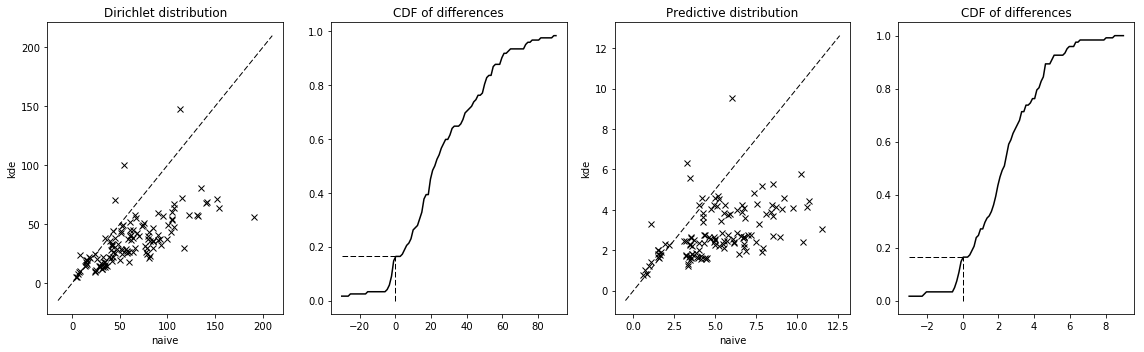

In [48]:
fig, axes = plt.subplots(ncols=4, figsize=(16,5))

bayesian = process_to_scores(all_data, lambda p, t : open_cp.evaluation.bayesian_dirichlet_prior(p, t, bias=5))
data = [PairedItem(k, bayesian[k][0], bayesian[k][1]) for k in bayesian]
scatter_uni_paired_plot_func(axes[0], data)
axes[0].set(xlabel="naive", ylabel="kde", title="Dirichlet distribution")
comparison_uni_paired(-30, 90)(axes[1], data)
axes[1].set(title="CDF of differences")

bayesian_pred = process_to_scores(all_data, lambda p, t : open_cp.evaluation.bayesian_predictive(p, t, bias=5))
data_pred = [PairedItem(k, bayesian_pred[k][0], bayesian_pred[k][1]) for k in bayesian_pred]
scatter_uni_paired_plot_func(axes[2], data_pred)
axes[2].set(xlabel="naive", ylabel="kde", title="Predictive distribution")
comparison_uni_paired(-3, 9)(axes[3], data_pred)
axes[3].set(title="CDF of differences")

fig.tight_layout()

In [49]:
if savefigures:
    fig.savefig("northside_bayes.pdf")

# Multi-level Brier

In [50]:
grid

MaskedGrid(offset=(355500,564600), size=150x150, mask region=70x80)

In [66]:
ms_brier = {s : 
    process_to_scores(all_data, lambda p, t : open_cp.evaluation.multiscale_brier_score(p, t, size=s))
            for s in range(1, 71)}

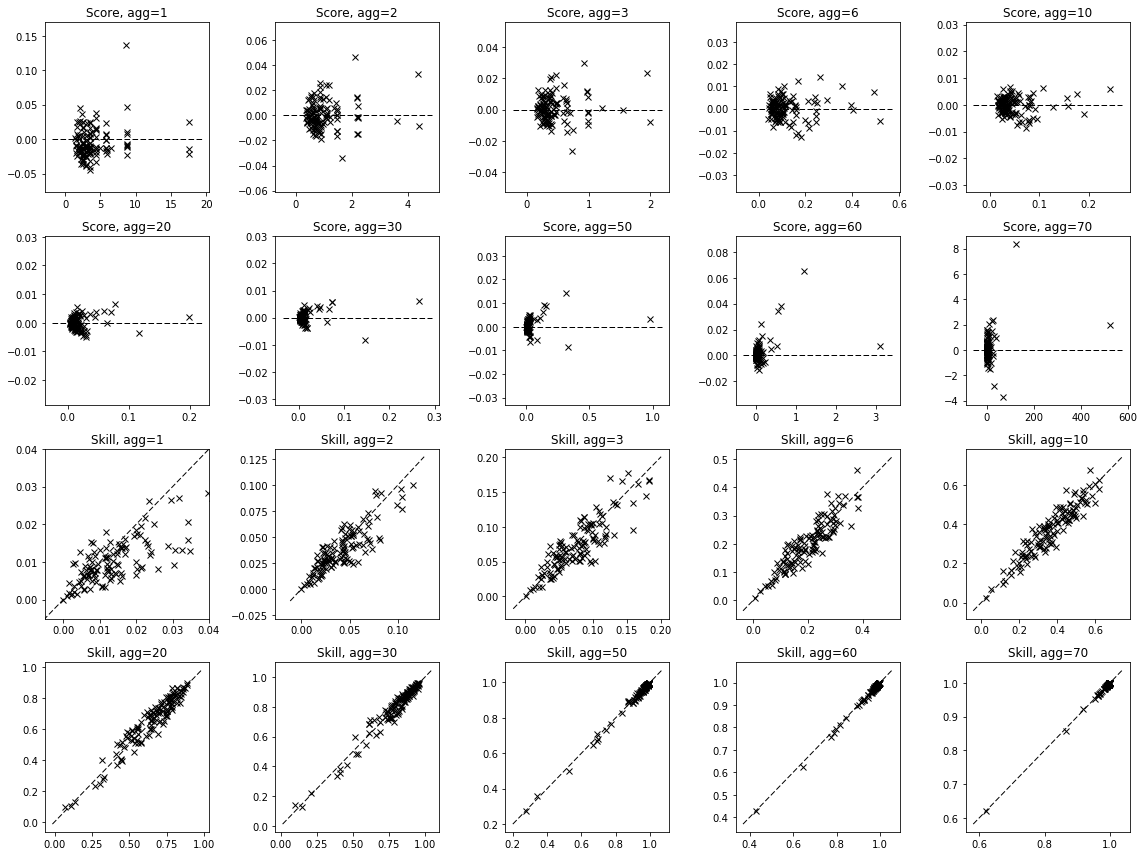

In [68]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16,12))

for ax, size in zip(axes.flatten(), [1,2,3,6,10, 20,30,50,60,70]):
    b = ms_brier[size]
    data = [PairedItem(k, b[k][0][0]*1e9, b[k][1][0]*1e9) for k in b]
    scatter_uni_paired_plot_func_diffs(ax, data)
    ax.set_title("Score, agg={}".format(size))
for ax, size in zip(axes.flatten()[10:], [1,2,3,6,10, 20,30,50,60,70]):
    b = ms_brier[size]
    data = [PairedItem(k, b[k][0][1], b[k][1][1]) for k in b]
    scatter_uni_paired_plot_func(ax, data)
    ax.set_title("Skill, agg={}".format(size))
axes[2][0].set(xlim=[-0.005, 0.04], ylim=[-0.005, 0.04])
fig.tight_layout()

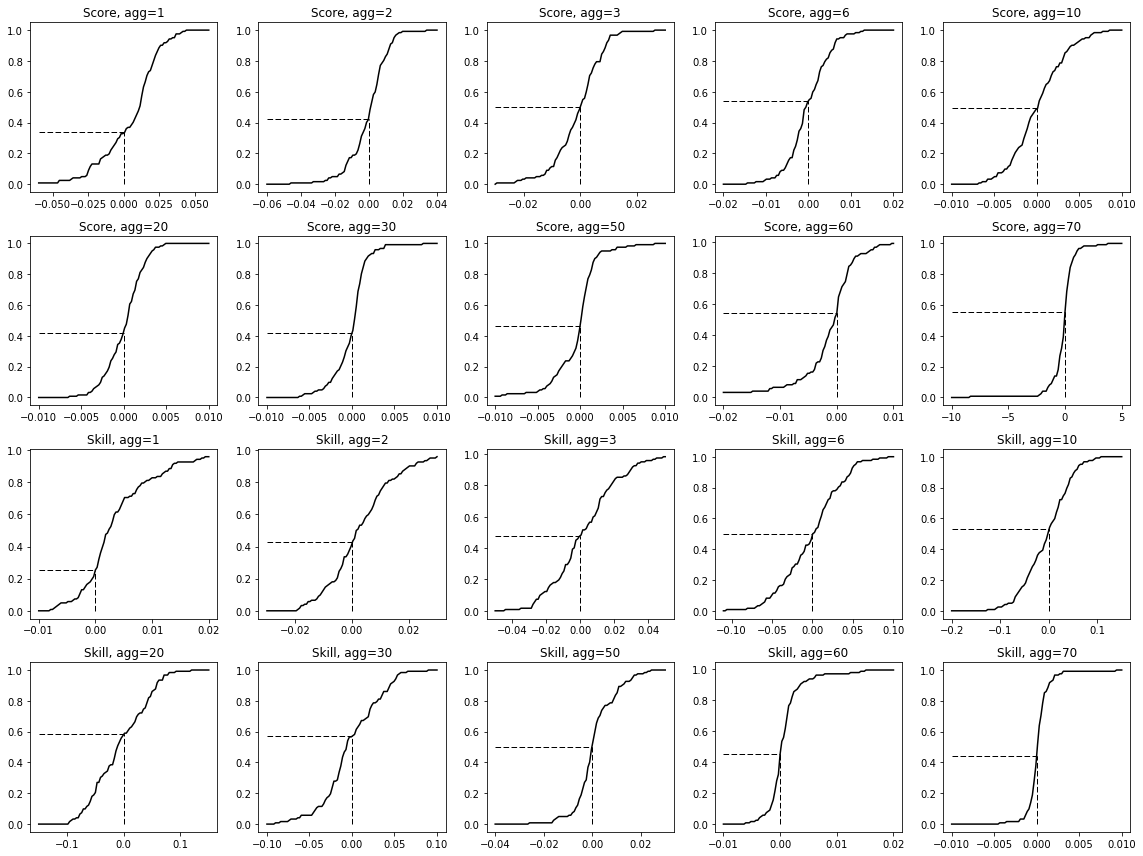

In [76]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16,12))

bounds = [(-0.06, 0.06), (-0.06, 0.04), (-0.03, 0.03), (-0.02, 0.02), (-0.01, 0.01),
          (-0.01, 0.01), (-0.01, 0.01), (-0.01, 0.01), (-0.02, 0.01), (-10,5)]
for ax, size, bo in zip(axes.flatten(), [1,2,3,6,10, 20,30,50,60,70], bounds):
    b = ms_brier[size]
    data = [PairedItem(k, b[k][0][0]*1e9, b[k][1][0]*1e9) for k in b]
    comparison_uni_paired(*bo)(ax, data)
    ax.set_title("Score, agg={}".format(size))

bounds = [(-0.01, 0.02), (-0.03, 0.03), (-0.05, 0.05), (-0.11, 0.1), (-0.2, 0.15),
         (-0.15, 0.15), (-0.1, 0.1), (-0.04, 0.03), (-0.01, 0.02), (-0.01, 0.01)]
for ax, size, bo in zip(axes.flatten()[10:], [1,2,3,6,10, 20,30,50,60,70], bounds):
    b = ms_brier[size]
    data = [PairedItem(k, b[k][0][1], b[k][1][1]) for k in b]
    func = comparison_uni_paired(*bo)(ax, data)
    ax.set_title("Skill, agg={}".format(size))
fig.tight_layout()

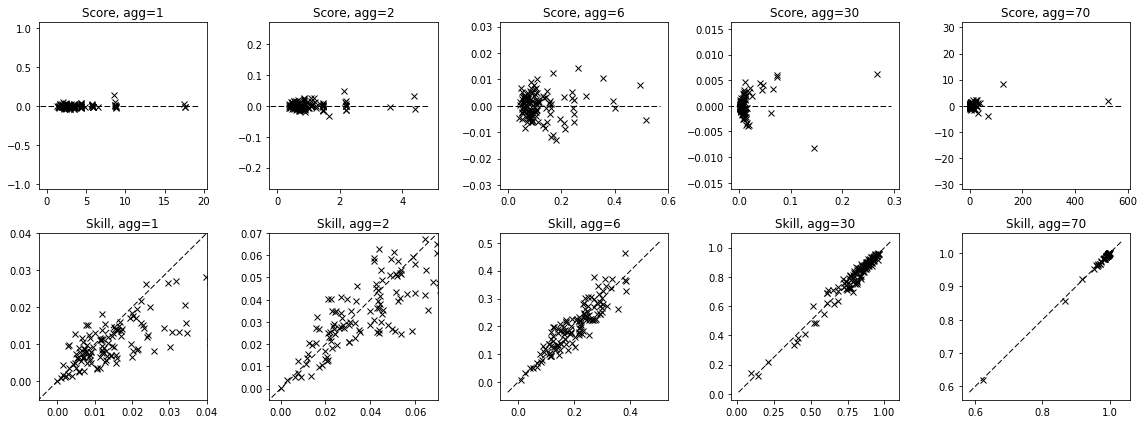

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))

for ax, size in zip(axes.flatten(), [1,2,6,30,70]):
    b = ms_brier[size]
    data = [PairedItem(k, b[k][0][0]*1e9, b[k][1][0]*1e9) for k in b]
    scatter_uni_paired_plot_func_diffs(ax, data)
    ax.set_title("Score, agg={}".format(size))
    x1 = ax.get_xlim()[1]
    ax.set(xlim=[-x1/20, x1])
    yr = (x1 * 21 / 20) / 20
    ax.set(ylim=[-yr, yr])
for ax, size in zip(axes.flatten()[5:], [1,2,6,30,70]):
    b = ms_brier[size]
    data = [PairedItem(k, b[k][0][1], b[k][1][1]) for k in b]
    scatter_uni_paired_plot_func(ax, data)
    ax.set_title("Skill, agg={}".format(size))
axes[1][0].set(xlim=[-0.005, 0.04], ylim=[-0.005, 0.04])
axes[1][1].set(xlim=[-0.005, 0.07], ylim=[-0.005, 0.07])
fig.tight_layout()

In [78]:
if savefigures:
    fig.savefig("multi_brier.pdf")

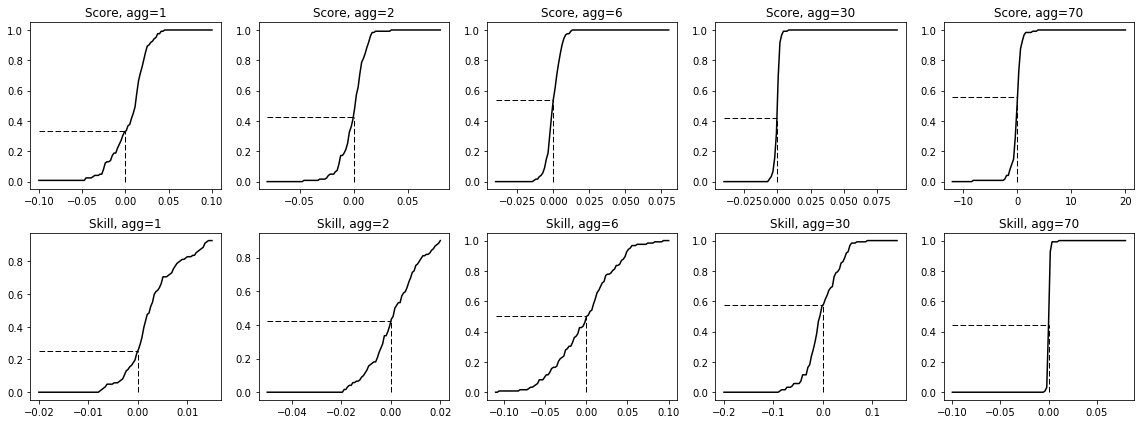

In [79]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))

bounds = [(-0.1, 0.1), (-0.08, 0.08), (-0.04, 0.08), (-0.04, 0.09), (-12,20)]
for ax, size, bo in zip(axes.flatten(), [1,2,6,30,70], bounds):
    b = ms_brier[size]
    data = [PairedItem(k, b[k][0][0]*1e9, b[k][1][0]*1e9) for k in b]
    comparison_uni_paired(*bo)(ax, data)
    ax.set_title("Score, agg={}".format(size))

bounds = [(-0.02, 0.015), (-0.05, 0.02), (-0.11, 0.1), (-0.2, 0.15), (-0.1, 0.08)]
for ax, size, bo in zip(axes.flatten()[5:], [1,2,6,30,70], bounds):
    b = ms_brier[size]
    data = [PairedItem(k, b[k][0][1], b[k][1][1]) for k in b]
    func = comparison_uni_paired(*bo)(ax, data)
    ax.set_title("Skill, agg={}".format(size))
fig.tight_layout()

In [80]:
if savefigures:
    fig.savefig("multi_brier_cpd.pdf")

Log scale estimated densities

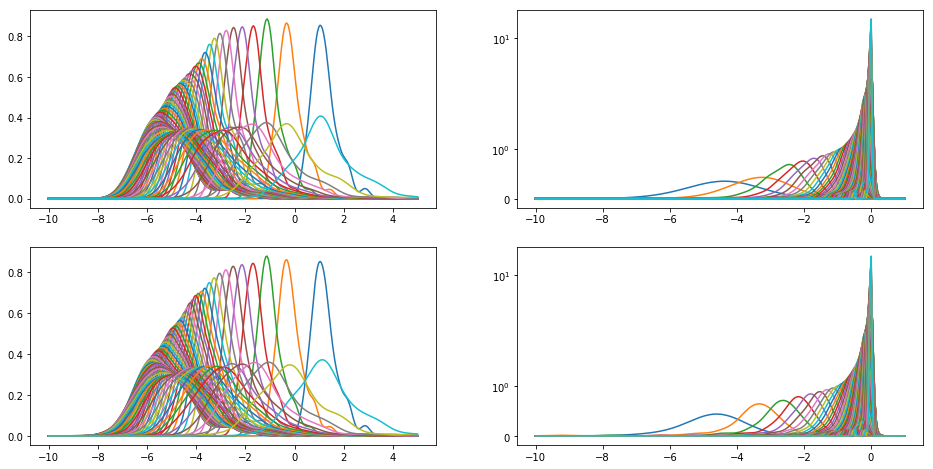

In [82]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,8))

ax = axes[0][0]
for size in ms_brier:
    data = np.log([v[0][0]*1e9 for v in ms_brier[size].values()])
    ker = scipy.stats.kde.gaussian_kde(data)
    x = np.linspace(-10,  5, 300)
    ax.plot(x, ker(x), label=size)

ax = axes[0][1]
for size in ms_brier:
    data = np.log([v[0][1] for v in ms_brier[size].values()])
    ker = scipy.stats.kde.gaussian_kde(data)
    x = np.linspace(-10,  1, 300)
    ax.plot(x, ker(x), label=size)
ax.set_yscale("symlog")

ax = axes[1][0]
for size in ms_brier:
    data = np.log([v[1][0]*1e9 for v in ms_brier[size].values()])
    ker = scipy.stats.kde.gaussian_kde(data)
    x = np.linspace(-10,  5, 300)
    ax.plot(x, ker(x), label=size)

ax = axes[1][1]
for size in ms_brier:
    data = np.log([v[1][1] for v in ms_brier[size].values()])
    ker = scipy.stats.kde.gaussian_kde(data)
    x = np.linspace(-10,  1, 300)
    ax.plot(x, ker(x), label=size)
ax.set_yscale("symlog")

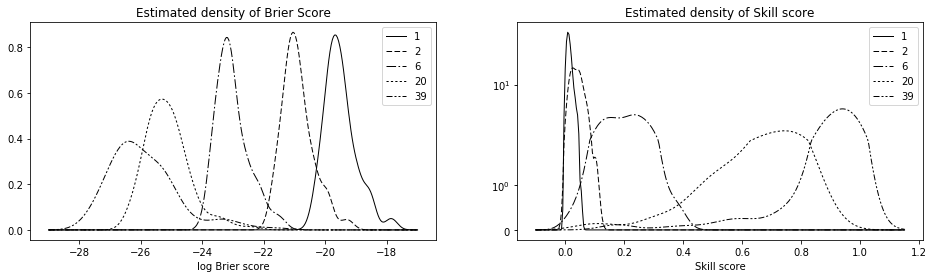

In [86]:
fig, axes = plt.subplots(ncols=2,figsize=(16,4))

sizes = [1,2,6,20,39]

ax = axes[0]
for size, ls in zip(sizes, ["-", "--", "-.", ":", (0,(3,1,1,1,1,1))]):
    data = np.log([v[0][0] for v in ms_brier[size].values()])
    ker = scipy.stats.kde.gaussian_kde(data)
    x = np.linspace(-29, -17, 300)
    ax.plot(x, ker(x), label=size, linestyle=ls, linewidth=1, color="black")
ax.legend()
ax.set(xlabel="log Brier score", title="Estimated density of Brier Score")
    
ax = axes[1]
for size, ls in zip(sizes, ["-", "--", "-.", ":", (0,(3,1,1,1,1,1))]):
    data = [v[0][1] for v in ms_brier[size].values()]
    ker = scipy.stats.kde.gaussian_kde(data)
    x = np.linspace(-0.1,  1.15, 300)
    ax.plot(x, ker(x), label=size, linestyle=ls, linewidth=1, color="black")
ax.set_yscale("symlog")
ax.set(xlabel="Skill score", title="Estimated density of Skill score")
ax.legend()
None

In [87]:
if savefigures:
    fig.savefig("multi_brier_dense.pdf")

**Other visualisation ideas**

In [88]:
keys = list(ms_brier[1])
ms_brier_by_date = {k : {s: ms_brier[s][k] for s in ms_brier} for k in keys}

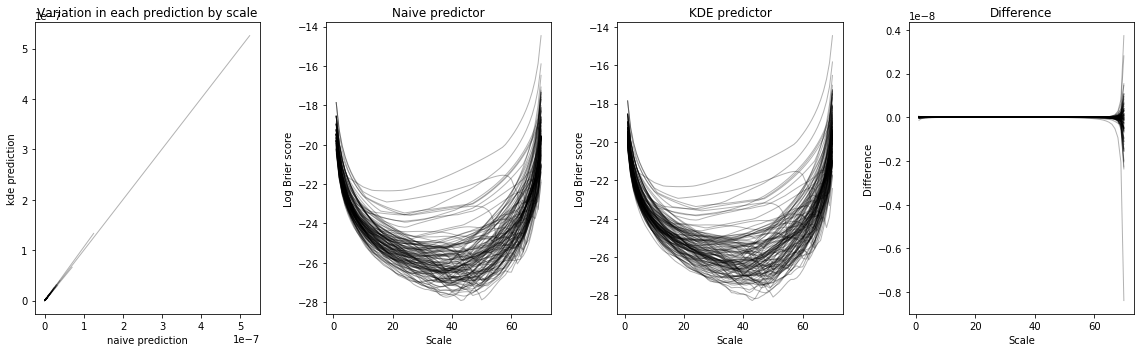

In [89]:
fig, ax = plt.subplots(ncols=4, figsize=(16,5))

for date_series in ms_brier_by_date.values():
    x = [p[0][0] for p in date_series.values()]
    y = [p[1][0] for p in date_series.values()]
    ax[0].plot(x, y, linewidth=1, color="black", alpha=0.3)
    
for date_series in ms_brier_by_date.values():
    x = list(date_series)
    y = [date_series[d][0][0] for d in x]
    ax[1].plot(x, np.log(y), linewidth=1, color="black", alpha=0.3)
    
for date_series in ms_brier_by_date.values():
    x = list(date_series)
    y = [date_series[d][1][0] for d in x]
    ax[2].plot(x, np.log(y), linewidth=1, color="black", alpha=0.3)

for date_series in ms_brier_by_date.values():
    x = list(date_series)
    y = [date_series[d][0][0] - date_series[d][1][0] for d in x]
    #y = np.max(y, 1e-30)
    ax[3].plot(x, y, linewidth=1, color="black", alpha=0.3)
    
ax[0].set(xlabel="naive prediction", ylabel="kde prediction")
ax[0].set_title("Variation in each prediction by scale")
ax[1].set(xlabel="Scale", ylabel="Log Brier score", title="Naive predictor")
ax[2].set(xlabel="Scale", ylabel="Log Brier score", title="KDE predictor")
ax[3].set(xlabel="Scale", ylabel="Difference", title="Difference")
fig.tight_layout()
None

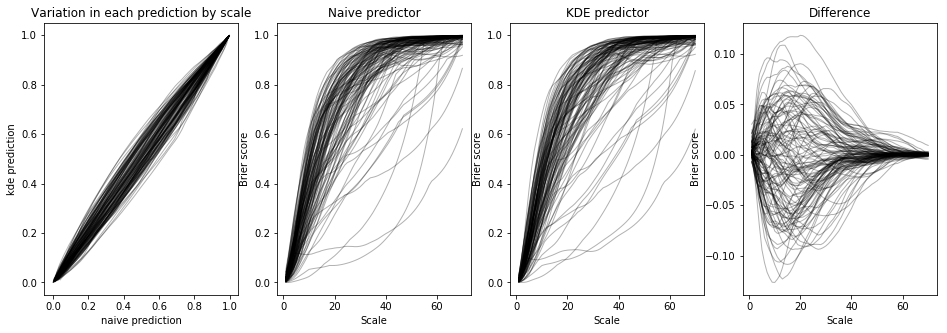

In [90]:
fig, ax = plt.subplots(ncols=4, figsize=(16,5))

for date_series in ms_brier_by_date.values():
    x = [p[0][1] for p in date_series.values()]
    y = [p[1][1] for p in date_series.values()]
    ax[0].plot(x, y, linewidth=1, color="black", alpha=0.3)
    
for date_series in ms_brier_by_date.values():
    x = list(date_series)
    y = [date_series[d][0][1] for d in x]
    ax[1].plot(x, y, linewidth=1, color="black", alpha=0.3)
    
for date_series in ms_brier_by_date.values():
    x = list(date_series)
    y = [date_series[d][1][1] for d in x]
    ax[2].plot(x, y, linewidth=1, color="black", alpha=0.3)
    
for date_series in ms_brier_by_date.values():
    x = list(date_series)
    y = [date_series[d][0][1] - date_series[d][1][1] for d in x]
    ax[3].plot(x, y, linewidth=1, color="black", alpha=0.3)
    
ax[0].set(xlabel="naive prediction", ylabel="kde prediction")
ax[0].set_title("Variation in each prediction by scale")
ax[1].set(xlabel="Scale", ylabel="Brier score", title="Naive predictor")
ax[2].set(xlabel="Scale", ylabel="Brier score", title="KDE predictor")
ax[3].set(xlabel="Scale", ylabel="Brier score", title="Difference")
None

We can try re-normalising, but it's not clear to me that the emperical min/max are reasonable to use here.

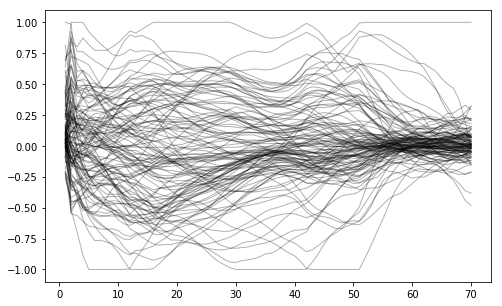

In [91]:
fig, ax = plt.subplots(figsize=(8,5))

x = list(date_series)
yy = []
for date_series in ms_brier_by_date.values():
    y = [date_series[d][0][1] - date_series[d][1][1] for d in x]
    yy.append(y)
low = np.asarray([min(y[k] for y in yy) for k in range(len(x))])
high = np.asarray([max(y[k] for y in yy) for k in range(len(x))])
maximum = np.asarray([max(abs(l), abs(h)) for l, h in zip(low, high)])
for y in yy:
    yd = np.asarray(y) / maximum
    ax.plot(x, yd, linewidth=1, color="black", alpha=0.3)

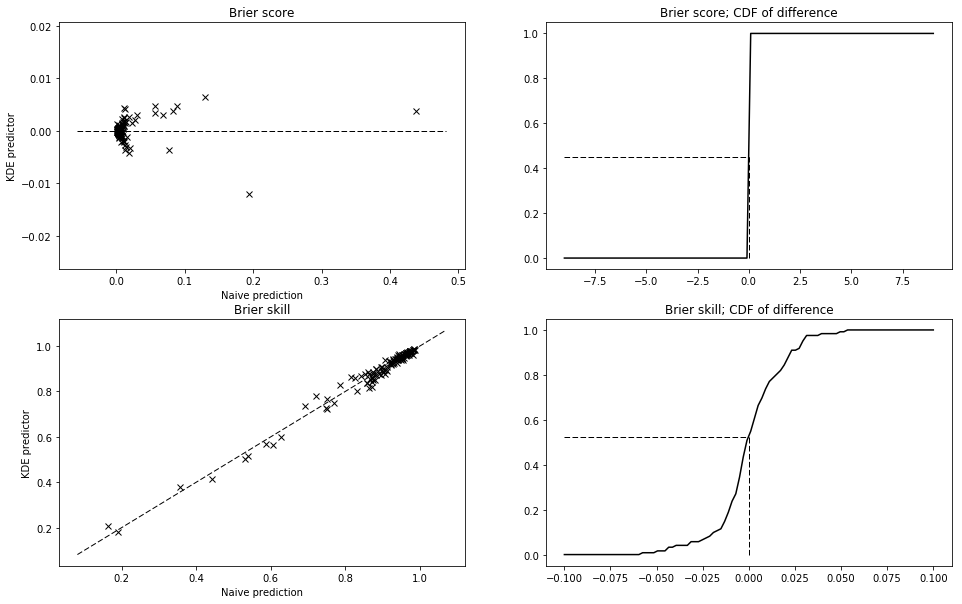

In [92]:
data = ms_brier[39]

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,10))

d = 1e9
data1 = [PairedItem(k, data[k][0][0] * d, data[k][1][0] * d) for k in data]

ax = axes[0][0]
scatter_uni_paired_plot_func_diffs(ax, data1)
ax.set(xlabel="Naive prediction", ylabel="KDE predictor", title="Brier score")
comparison_uni_paired(-9, 9)(axes[0][1], data1)
axes[0][1].set(title="Brier score; CDF of difference")

data1 = [PairedItem(k, data[k][0][1], data[k][1][1]) for k in data]

ax = axes[1][0]
scatter_uni_paired_plot_func(ax, data1)
ax.set(xlabel="Naive prediction", ylabel="KDE predictor", title="Brier skill")
comparison_uni_paired(-.1, .1)(axes[1][1], data1)
axes[1][1].set(title="Brier skill; CDF of difference")
None